## Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import geopandas as gpd

## Internet usage vs Age

## Load data

In [2]:
gdp = pd.read_csv('data/DCIS_INDDEMOG1_29102020101648279.csv')
gdp.drop(['ITTER107', 'TIPO_DATO15', 'Select time', 'Flag Codes', 'Flags'], axis=1, inplace=True)
gdp.head(10)

,Territory,Indicator,TIME,Value
0,Piemonte,mean age of the population - on 1st January,2015,46.2
1,Piemonte,mean age of the population - on 1st January,2016,46.4
2,Piemonte,mean age of the population - on 1st January,2017,46.6
3,Piemonte,mean age of the population - on 1st January,2018,46.8
4,Piemonte,mean age of the population - on 1st January,2019,47.0
5,Piemonte,mean age of the population - on 1st January,2020,47.3
6,Valle d'Aosta / Vallée d'Aoste,mean age of the population - on 1st January,2015,45.1
7,Valle d'Aosta / Vallée d'Aoste,mean age of the population - on 1st January,2016,45.3
8,Valle d'Aosta / Vallée d'Aoste,mean age of the population - on 1st January,2017,45.6
9,Valle d'Aosta / Vallée d'Aoste,mean age of the population - on 1st January,2018,45.9


In [30]:
df = pd.read_csv('data/internet_usage.csv')
df.drop(['ITTER107', 'TIPO_DATO_AVQ', 'MISURA_AVQ', 'MISURA_AVQ', 'Select time', 'Flag Codes', 'Flags'], axis=1, inplace=True)

# Delete rows with year = 2019, since we do not have the GDP data for that year
#df = df.loc[~(df['TIME'] <= 2019),:]

df = df.loc[~(df['Territory'] == "Provincia Autonoma Trento"),:]
df = df.loc[~(df['Territory'] == "Provincia Autonoma Bolzano / Bozen"),:]

df.head()

,Territory,Data type,Measure,TIME,Value
0,Marche,they use Internet,per 100 people with the same characteristics,2018,69.2
1,Marche,they use Internet,per 100 people with the same characteristics,2019,70.0
2,Toscana,they use Internet,per 100 people with the same characteristics,2018,71.8
3,Toscana,they use Internet,per 100 people with the same characteristics,2019,73.7
4,Piemonte,they use Internet,per 100 people with the same characteristics,2018,69.7


## Compute the surprise data

In [4]:
surprise_data = []
for index, region in enumerate(df['Territory'].unique()):
    surprise_data.append([])
    for _ in range(len(df['TIME'].unique())): # 2
        surprise_data[index].append(0)

In [5]:
surprise_data

[[0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0]]

Start with equiprobably P(M)s

For each year:

- Calculate observed-expected
- Estimate P(D|M)
- Estimate P(M|D)
- Surprise is D_KL ( P(M|D) || P(M) )
- Normalize so sum P(M)s = 1

For now, let's use only one model. We have to include inside our prior the economic status of the regions: an idea could be to take the GDP of each region and assume that the higher the GDP the higher the interaction with the public authorities. More precisely, we can assume that the highest GDP will correspond to the highest rate of interaction, and so on...

In [16]:
# Since we have only one model...
pM = 1

# FOR NOW LET'S FOCUS ONLY ON THE 'OBTAINING INFORMATION' INTERACTION

for k, year in enumerate(df['TIME'].unique()):
    # Compute the average rate of the current year
    avg_rate = np.mean(df.loc[(df['TIME'] == year) & (df['Data type'] == 'they use Internet')]['Value'])
    # Compute the sum of the rates of the current year
    sum_rate = np.sum(df.loc[(df['TIME'] == year) & (df['Data type'] == 'they use Internet')]['Value'])
    
    # Get the list of regions ordered by GDP of the current year
    current_gdp = gdp.loc[gdp['TIME'] == year].sort_values(by=['Value'], ascending=False)
    
    for j, region in enumerate(df['Territory'].unique()):
        # Estimate P(D|M) as 1 - |O - E|
        O = (df.loc[(df['TIME'] == year) & (df['Territory'] == region) & (df['Data type'] == 'they use Internet')]['Value'] / sum_rate).item()
        # Get the region with the highest GDP in the current year
        highest_gdp = gdp.loc[gdp['TIME'] == year].max()['Territory']
        # Get the index of the current region in the ordered GDP list
        index = list(current_gdp['Territory']).index(region)
        # Get the current data observed and sort them
        obs_data = df.loc[(df['TIME'] == year) & (df['Data type'] == 'they use Internet')]
        obs_data.sort_values(by=['Value'], ascending=False, inplace=True)
        # Get the expected value
        E = (obs_data.iloc[index]['Value'] / sum_rate).item()
        
        # P(D|M)
        pDM = 1 - np.abs(O - E)
        
        # Estimate P(M|D)
        pMD = pDM * pM
        
        # Surprise is the sum of KL divergance across model space (only one here)
        kl = pMD * (np.log(pMD / pM) / np.log(2))
        surprise_data[j][k] = np.abs(kl) if (O - E) > 0 else -np.abs(kl)
        
    # Now let's globally update our model belief
    pDM = 1 - (0.5 * np.abs(O - E))
    pMD = pDM * pM
    pM = pMD

C:\Users\Roncax\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.9998895271763146
0.998415294199681
0.9983049964429201
0.9968330996918355
0.9967229767245696
0.9952534124968039
0.9951434640420429
0.993676228641233
0.993566454422426
0.9921015441580661


## Plot the result

In [17]:
# Starting from the surprise data, create a dataframe
df_structure = {}
for region in df['Territory'].unique():
    df_structure[region] = []
for index, region in enumerate(df_structure):
    df_structure[region] = surprise_data[index]

surprise_df = pd.DataFrame(df_structure).transpose()
surprise_df.index.name = 'Territory'
surprise_df.columns = [str(year) for year in df['TIME'].unique()]

In [18]:
surprise_df.head(20)

,2018,2019
Territory,,
Marche,-0.001688,-0.001237
Toscana,-0.001055,-0.000000
Piemonte,-0.003691,-0.003501
Friuli-Venezia Giulia,-0.000422,-0.000618
Valle d'Aosta / Vallée d'Aoste,-0.000000,-0.000000
Puglia,-0.000000,-0.002369
Trentino Alto Adige / Südtirol,0.014391,0.013339
Veneto,0.004954,0.004015
Liguria,-0.002426,-0.005351


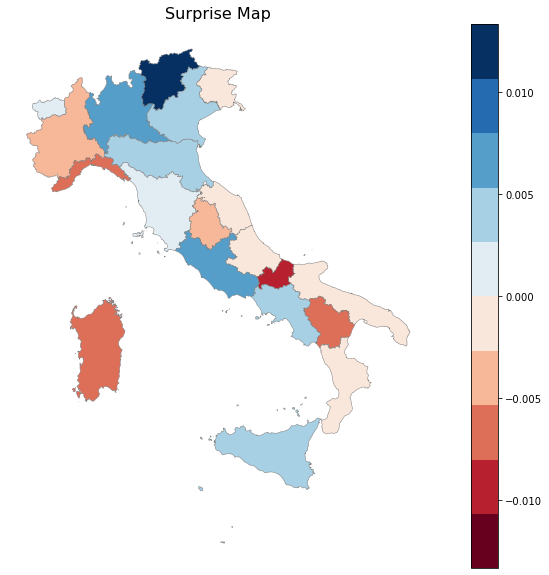

In [19]:
map_reg = gpd.read_file(os.path.join('..', 'assets', 'maps', 'Reg01012019_g', 'Reg01012019_g_WGS84.shp'))
map_reg['DEN_REG'] = map_reg['DEN_REG'].replace({'Friuli Venezia Giulia': 'Friuli-Venezia Giulia', 'Trentino-Alto Adige': 'Trentino Alto Adige / Südtirol', "Valle d'Aosta": "Valle d'Aosta / Vallée d'Aoste"})
# Merge the map with the pandas df
merged = pd.merge(map_reg, surprise_df, left_on='DEN_REG', right_on='Territory', how='left')

YEAR = '2019'
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.axis('off')
ax.set_title('Surprise Map', fontsize=16)
cmap = plt.get_cmap('RdBu', 10)
max_abs_value = max(np.abs(min(merged[YEAR])), np.abs(max(merged[YEAR])))
merged.plot(column=YEAR, vmin = -max_abs_value, vmax = max_abs_value, cmap=cmap, linewidth=0.5, ax=ax, edgecolor='0.5', legend=True)

## Internet usage vs Diploma

In [47]:
gdp = pd.read_csv('data/DCIS_LAUREATI_29102020101227524.csv')
gdp.drop(['ITTER107', 'TIPO_DATO6', 'Select time', 'Flag Codes', 'Flags', 'Type of data', 'AREADIDATTICA', 'Type of university', 'NATGIUR', 'TIPCORSOLAUREA', 'SEXISTAT1' ], axis=1, inplace=True)

gdp = gdp.loc[(gdp['Type of programme'] == "total"),:]
gdp = gdp.loc[(gdp['Field of study'] == "total"),:]
gdp = gdp.loc[(gdp['Gender'] == "total"),:]
gdp = gdp.rename(columns={'Region of study': 'Territory'})

gdp = gdp.loc[~(gdp['Territory'] == "Provincia Autonoma Trento"),:]
gdp = gdp.loc[~(gdp['Territory'] == "Provincia Autonoma Bolzano / Bozen"),:]

gdp.head(50)

,Territory,Gender,Type of programme,Field of study,TIME,Value
3656,Piemonte,total,total,total,2016,20428
3668,Valle d'Aosta / Vallée d'Aoste,total,total,total,2016,212
3683,Liguria,total,total,total,2016,5954
3698,Lombardia,total,total,total,2016,55095
3713,Trentino Alto Adige / Südtirol,total,total,total,2016,4437
3755,Veneto,total,total,total,2016,22640
3770,Friuli-Venezia Giulia,total,total,total,2016,6011
3785,Emilia-Romagna,total,total,total,2016,29434
3800,Toscana,total,total,total,2016,18375
3815,Umbria,total,total,total,2016,4688


In [48]:
df = pd.read_csv('data/internet_usage.csv')
df.drop(['ITTER107', 'TIPO_DATO_AVQ', 'MISURA_AVQ', 'MISURA_AVQ', 'Select time', 'Flag Codes', 'Flags'], axis=1, inplace=True)

# Delete rows with year = 2019, since we do not have the GDP data for that year
#df = df.loc[~(df['TIME'] <= 2019),:]

df = df.loc[~(df['Territory'] == "Provincia Autonoma Trento"),:]
df = df.loc[~(df['Territory'] == "Provincia Autonoma Bolzano / Bozen"),:]

df.head()

,Territory,Data type,Measure,TIME,Value
0,Marche,they use Internet,per 100 people with the same characteristics,2018,69.2
1,Marche,they use Internet,per 100 people with the same characteristics,2019,70.0
2,Toscana,they use Internet,per 100 people with the same characteristics,2018,71.8
3,Toscana,they use Internet,per 100 people with the same characteristics,2019,73.7
4,Piemonte,they use Internet,per 100 people with the same characteristics,2018,69.7


In [49]:
surprise_data = []
for index, region in enumerate(df['Territory'].unique()):
    surprise_data.append([])
    for _ in range(len(df['TIME'].unique())): # 2
        surprise_data[index].append(0)

In [51]:
# Since we have only one model...
pM = 1

# FOR NOW LET'S FOCUS ONLY ON THE 'OBTAINING INFORMATION' INTERACTION

for k, year in enumerate(df['TIME'].unique()):
    # Compute the average rate of the current year
    avg_rate = np.mean(df.loc[(df['TIME'] == year) & (df['Data type'] == 'they use Internet')]['Value'])
    # Compute the sum of the rates of the current year
    sum_rate = np.sum(df.loc[(df['TIME'] == year) & (df['Data type'] == 'they use Internet')]['Value'])
    
    # Get the list of regions ordered by GDP of the current year
    current_gdp = gdp.sort_values(by=['Value'], ascending=False)
    
    for j, region in enumerate(df['Territory'].unique()):
        # Estimate P(D|M) as 1 - |O - E|
        O = (df.loc[(df['TIME'] == year) & (df['Territory'] == region) & (df['Data type'] == 'they use Internet')]['Value'] / sum_rate).item()
        # Get the region with the highest GDP in the current year
        highest_gdp = gdp.max()['Territory']
        # Get the index of the current region in the ordered GDP list
        index = list(current_gdp['Territory']).index(region)
        # Get the current data observed and sort them
        obs_data = df.loc[(df['TIME'] == year) & (df['Data type'] == 'they use Internet')]
        obs_data.sort_values(by=['Value'], ascending=False, inplace=True)
        # Get the expected value
        E = (obs_data.iloc[index]['Value'] / sum_rate).item()
        
        # P(D|M)
        pDM = 1 - np.abs(O - E)
        
        # Estimate P(M|D)
        pMD = pDM * pM
        
        # Surprise is the sum of KL divergance across model space (only one here)
        kl = pMD * (np.log(pMD / pM) / np.log(2))
        surprise_data[j][k] = np.abs(kl) if (O - E) > 0 else -np.abs(kl)
        
    # Now let's globally update our model belief
    pDM = 1 - (0.5 * np.abs(O - E))
    pMD = pDM * pM
    pM = pMD

C:\Users\Roncax\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [52]:
# Starting from the surprise data, create a dataframe
df_structure = {}
for region in df['Territory'].unique():
    df_structure[region] = []
for index, region in enumerate(df_structure):
    df_structure[region] = surprise_data[index]

surprise_df = pd.DataFrame(df_structure).transpose()
surprise_df.index.name = 'Territory'
surprise_df.columns = [str(year) for year in df['TIME'].unique()]

In [53]:
surprise_df.head(20)

,2018,2019
Territory,,
Marche,-0.000212,-0.000000
Toscana,0.001062,0.002582
Piemonte,-0.002230,-0.002375
Friuli-Venezia Giulia,0.007313,0.005571
Valle d'Aosta / Vallée d'Aoste,0.010270,0.008142
Puglia,-0.007630,-0.008039
Trentino Alto Adige / Südtirol,0.013746,0.011735
Veneto,-0.000956,-0.000620
Liguria,0.006784,0.002582


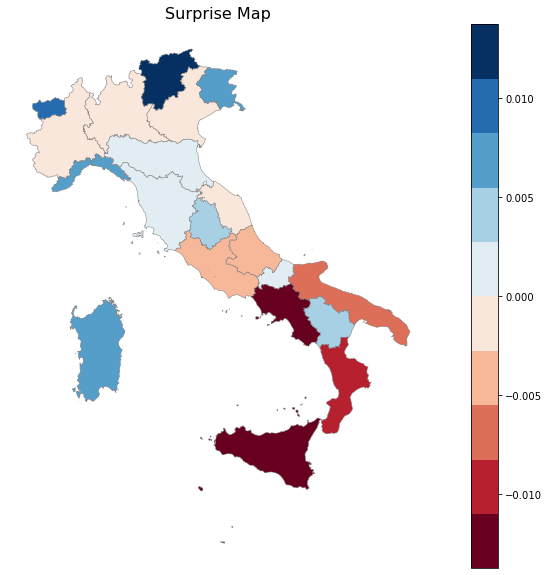

In [55]:
map_reg = gpd.read_file(os.path.join('..', 'assets', 'maps', 'Reg01012019_g', 'Reg01012019_g_WGS84.shp'))
map_reg['DEN_REG'] = map_reg['DEN_REG'].replace({'Friuli Venezia Giulia': 'Friuli-Venezia Giulia', 'Trentino-Alto Adige': 'Trentino Alto Adige / Südtirol', "Valle d'Aosta": "Valle d'Aosta / Vallée d'Aoste"})
# Merge the map with the pandas df
merged = pd.merge(map_reg, surprise_df, left_on='DEN_REG', right_on='Territory', how='left')

YEAR = '2018'
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.axis('off')
ax.set_title('Surprise Map', fontsize=16)
cmap = plt.get_cmap('RdBu', 10)
max_abs_value = max(np.abs(min(merged[YEAR])), np.abs(max(merged[YEAR])))
merged.plot(column=YEAR, vmin = -max_abs_value, vmax = max_abs_value, cmap=cmap, linewidth=0.5, ax=ax, edgecolor='0.5', legend=True)